# Introduction
This is modified a notebook version of the TFT model script written in TF2 folder. This works with both the old and new dataset.If you are switching dataset, be sure to change both input csv and `config.json` files. They can be found in the `TF2\Notebooks\2022_May` or `TF2\Notebooks\2021_Nov` folder.  This notebook used the input files in `TF2\Notebooks\2022_May` folder. You can recreate them using the `Data preparation` notebook in this same folder. For a fresh model training, remove any files from the `checkpoint` folder.

It is modified to run on colab. If you want to run on your local machine, you can use the model scripts in the TF2 folder instead. Run the model on GPU or reduce `epochs` in `config.json`.

The input dataset is splitted into three parts here based on the following dates

* `Train`: From `2020-02-28` to `2021-11-22`
* `Validation`: From `2021-11-23` to `2022-02-18`
* `Test`: From `2022-02-19` to `2022-05-17`

# Initial Setup
## Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import Progbar
import os, time, gc
import numpy as np
import pandas as pd
from tensorflow.python.training.checkpoint_management import CheckpointManager

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Apply the default theme
sns.set_theme()
sns.set(font_scale = 1.5)

import json


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Adding google drive
Set `running_on_colab= False` if running locally.

In [3]:
running_on_colab = True

if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/My Drive/Projects/Covid/TF2

Mounted at /content/drive
/content/drive/My Drive/Projects/Covid/TF2


## Setting up folders
The current folder has the following structure

TF2
* checkpoints
* data
  * Top_500.csv
* config.json

## For new dataset
You can collect `Top_500.csv` and `config.json` for new dataset in in the `TF2\Notebooks\2022_May` folder. 

### For the old dataset 
Collect `Top_500.csv` and `config.json` in the `TF2\Notebooks\2021_Nov` folder. 

In [ ]:
checkPointPath = "keras checkpoints"
if not os.path.exists(checkPointPath):
  os.makedirs(checkPointPath, exist_ok=True)

dataPath = "data/Top_500.csv"
figPath = 'figure/'
configPath = 'data/config.json'

In [ ]:
with open(configPath) as inputfile:
  config = json.load(inputfile)
  inputfile.close()

## Load data

In [ ]:
df = pd.read_csv(dataPath)
# print(df.shape)
df.head()

,FIPS,AgeDist,AirPollution,HealthDisp,Name,Date,DiseaseSpread,Transmission,VaccinationFull,SocialDist,Cases,TimeFromStart,LinearSpace,Constant,LinearTime,P2Time,P3Time,P4Time,CosWeekly,SinWeekly
0,1003,0.6095,0.4371,0.2039,"Alabama, Baldwin",2020-02-28,0.0,0.0,0.0,1.0,0.0,0,0.0003,0.5,0.0000,1.0000,-1.0000,1.0000,-0.9010,-0.4339
1,1003,0.6095,0.4371,0.2039,"Alabama, Baldwin",2020-02-29,0.0,0.0,0.0,1.0,0.0,1,0.0003,0.5,0.0012,0.9926,-0.9852,0.9754,-0.2225,-0.9749
2,1003,0.6095,0.4371,0.2039,"Alabama, Baldwin",2020-03-01,0.0,0.0,0.0,1.0,0.0,2,0.0003,0.5,0.0025,0.9852,-0.9705,0.9511,0.6235,-0.7818
3,1003,0.6095,0.4371,0.2039,"Alabama, Baldwin",2020-03-02,0.0,0.0,0.0,1.0,0.0,3,0.0003,0.5,0.0037,0.9778,-0.9559,0.9271,1.0000,0.0000
4,1003,0.6095,0.4371,0.2039,"Alabama, Baldwin",2020-03-03,0.0,0.0,0.0,1.0,0.0,4,0.0003,0.5,0.0049,0.9705,-0.9414,0.9033,0.6235,0.7818


In [ ]:
df['VaccinationFull'] /= 100
df['Date'] = pd.to_datetime(df['Date']) 
df['FIPS'] = df['FIPS'].astype(str)

# Classes

## TFT Model

In [ ]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    """Defines scaled dot product attention layer.

    Attributes:
    dropout: Dropout rate to use
    activation: Normalisation function for scaled dot product attention (e.g.
      softmax by default)
    """

    def __init__(self, attn_dropout=0.0):
        super(ScaledDotProductAttention, self).__init__()
        self.dropout = tf.keras.layers.Dropout(attn_dropout)
        self.activation = tf.keras.layers.Activation('softmax')

    def call(self, q, k, v, mask):
        """Applies scaled dot product attention.

        Args:
          q: Queries
          k: Keys
          v: Values
          mask: Masking if required -- sets softmax to very large value

        Returns:
          Tuple of (layer outputs, attention weights)
        """
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        temper = tf.sqrt(tf.cast(tf.shape(k)[-1], dtype='float32'))
        attn = matmul_qk / temper

        if mask is not None:
            mmask = mask * -1e9  # setting to infinity
            attn = tf.keras.layers.Add()([attn, mmask])

        attn = self.activation(attn)
        attn = self.dropout(attn)
        output = tf.matmul(attn, v)

        return output, attn


class InterpretableMultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, n_head, d_model, dropout):
        """Initialises layer.

        Args:
        n_head: Number of heads
        d_model: TFT state dimensionality
        dropout: Dropout discard rate
        """
        super(InterpretableMultiHeadAttention, self).__init__()

        self.n_head = n_head
        self.d_k = self.d_v = d_k = d_v = d_model // n_head
        self.dropout = dropout

        # Use same value layer to facilitate interp
        vs_layer = tf.keras.layers.Dense(d_v, use_bias=False)

        self.qs_layers = [tf.keras.layers.Dense(d_k, use_bias=False) for _ in range(n_head)]
        self.ks_layers = [tf.keras.layers.Dense(d_k, use_bias=False) for _ in range(n_head)]
        self.vs_layers = [vs_layer for _ in range(n_head)]

        self.attention = ScaledDotProductAttention()
        self.w_o = tf.keras.layers.Dense(d_model, use_bias=False)

    def call(self, q, k, v, mask=None):
        n_head = self.n_head

        heads = tf.TensorArray(tf.float32, n_head)
        attns = tf.TensorArray(tf.float32, n_head)

        for i in range(self.n_head):
            qs = self.qs_layers[i](q)
            ks = self.ks_layers[i](q)
            vs = self.vs_layers[i](q)
            head, attn = self.attention(qs, ks, vs, mask)

            head_dropout = tf.keras.layers.Dropout(self.dropout)(head)
            heads = heads.write(i, head_dropout)
            attns = attns.write(i, attn)

        head = heads.stack()
        attn = attns.stack()

        outputs = tf.math.reduce_mean(head, axis=0) if n_head > 1 else head
        outputs = self.w_o(outputs)
        outputs = tf.keras.layers.Dropout(self.dropout)(outputs)  # output dropout

        return outputs, attn


class HiD_EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, time_steps, known_reg_inputs,
                 future_inputs, static_inputs, target_loc, unknown_len, hls=64, cat_inputs=None):
        super(HiD_EmbeddingLayer, self).__init__()

        self.time_steps = time_steps
        self.known_locs = known_reg_inputs
        self.future_locs = future_inputs
        self.static_locs = static_inputs
        self.unknown_length = unknown_len

        self.target_loc = target_loc

        if cat_inputs:
            self.cat = cat_inputs

        self.hls = hls

        self.sd = [tf.keras.layers.Dense(hls) for s in range(len(static_inputs))]

        self.real_conversion_unknown = [tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hls)) \
                                        for i in range(unknown_len)]

        self.real_conversion_known = [tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hls)) \
                                      for i in range(len(known_reg_inputs))]

        self.real_conversion_target = [tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hls)) \
                                       for i in range(len(target_loc))]

    def call(self, known_inputs, unknown_inputs, static_inputs):
        """
        Not set up for categorical inputs currently - therefore regular inputs = inputs

        First trial we will ignore the targets
        """

        static_inputs = tf.stack([self.sd[sdx](s) for sdx, s in enumerate(static_inputs)], axis=1)

        unknown_inputs = tf.stack([self.real_conversion_unknown[udx](u) \
                                   for udx, u in enumerate(unknown_inputs)], axis=-1)

        known_inputs = tf.stack([self.real_conversion_known[kdx](k) for kdx, k in enumerate(known_inputs)], axis=-1)

        return known_inputs, unknown_inputs, static_inputs  # , target_inputs


class LinearLayer(tf.keras.layers.Layer):

    def __init__(self, size, use_time_distributed, use_bias=True, activation=None):
        super(LinearLayer, self).__init__()

        self.size = size
        self.use_time_distributed = use_time_distributed
        self.use_bias = use_bias
        self.activation = activation

        self.out_linear = tf.keras.layers.Dense(size, activation, use_bias)
        if use_time_distributed:
            self.out_linear = tf.keras.layers.TimeDistributed(self.out_linear)

    def call(self, inputs):
        output = self.out_linear(inputs)

        return output


class GLU(tf.keras.layers.Layer):

    def __init__(self, hls=64, use_time_distributed=True, dropout_rate=None, activation=None):

        super(GLU, self).__init__()

        self.hls = hls
        self.use_time_distributed = use_time_distributed
        self.dropout_rate = dropout_rate
        self.activation = activation

        self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

        if use_time_distributed:
            self.activation_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hls, activation))
            self.gate_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hls, activation='sigmoid'))
        else:
            self.activation_layer = tf.keras.layers.Dense(hls, activation)
            self.gate_layer = tf.keras.layers.Dense(hls, activation='sigmoid')

        self.return_layer = tf.keras.layers.Multiply()

    def call(self, inputs):

        if self.dropout_rate:
            inputs = self.dropout_layer(inputs)

        activation_layer = self.activation_layer(inputs)

        gate_layer = self.gate_layer(inputs)

        return self.return_layer([activation_layer, gate_layer]), gate_layer


class GatedResidualNetwork(tf.keras.layers.Layer):
    '''
    This class is only used for GRN's without added context. For layers which use context see TemporalGatedResidualNetwork
    '''

    def __init__(self, hls=64, output_size=None,
                 dropout_rate=None, use_time_distributed=True,
                 return_gate=False, altered_glu=False):

        super(GatedResidualNetwork, self).__init__()
        self.hls = hls
        self.use_time_distributed = use_time_distributed
        self.return_gate = return_gate

        self.output_size = output_size

        self.dropout_rate = dropout_rate
        self.additional_context = None

        self.linear = LinearLayer(hls, activation=None,
                                  use_time_distributed=self.use_time_distributed)

        self.linear_hidden = LinearLayer(hls, activation=None,
                                         use_time_distributed=self.use_time_distributed)
        self.linear_additional_context = LinearLayer(hls, activation=None,
                                                     use_time_distributed=use_time_distributed,
                                                     use_bias=False)

        if output_size:
            self.out_linear = tf.keras.layers.Dense(output_size)
            if use_time_distributed:
                self.out_linear = tf.keras.layers.TimeDistributed(self.out_linear)

        if altered_glu:
            self.gate_layer = GLU(output_size, dropout_rate=self.dropout_rate,
                                  use_time_distributed=self.use_time_distributed, activation=None)
        else:
            self.gate_layer = GLU(hls, dropout_rate=self.dropout_rate,
                                  use_time_distributed=self.use_time_distributed, activation=None)

        self.norm = tf.keras.layers.LayerNormalization()

        self.hidden_activation = tf.keras.layers.Activation('elu')

        self.add_layer1 = tf.keras.layers.Add()
        self.add_layer2 = tf.keras.layers.Add()

    def call(self, inputs):

        if self.output_size is None:
            output_size = self.hls
            skip = inputs
        else:
            skip = self.out_linear(inputs)

        hidden0 = self.linear(inputs)

        hidden1 = self.hidden_activation(hidden0)
        hidden2 = self.linear_hidden(hidden1)

        gating_layer, gate = self.gate_layer(hidden2)

        tmp = self.add_layer2([skip, gating_layer])
        ann = self.norm(tmp)

        if self.return_gate:
            return ann, gate
        else:
            return ann


class TemporalGatedResidualNetwork(tf.keras.layers.Layer):

    def __init__(self, hls=64, output_size=None,
                 dropout_rate=None, use_time_distributed=True,
                 return_gate=False, altered_glu=False):

        super(TemporalGatedResidualNetwork, self).__init__()
        self.hls = hls
        self.use_time_distributed = use_time_distributed
        self.return_gate = return_gate

        self.output_size = output_size

        self.dropout_rate = dropout_rate
        self.additional_context = None

        self.linear = LinearLayer(hls, activation=None,
                                  use_time_distributed=self.use_time_distributed)

        self.linear_hidden = LinearLayer(hls, activation=None,
                                         use_time_distributed=self.use_time_distributed)
        self.linear_additional_context = LinearLayer(hls, activation=None,
                                                     use_time_distributed=use_time_distributed,
                                                     use_bias=False)

        if output_size:
            self.out_linear = tf.keras.layers.Dense(output_size)
            if use_time_distributed:
                self.out_linear = tf.keras.layers.TimeDistributed(self.out_linear)

        if altered_glu:
            self.gate_layer = GLU(output_size, dropout_rate=self.dropout_rate,
                                  use_time_distributed=self.use_time_distributed, activation=None)
        else:
            self.gate_layer = GLU(hls, dropout_rate=self.dropout_rate,
                                  use_time_distributed=self.use_time_distributed, activation=None)

        self.norm = tf.keras.layers.LayerNormalization()

        self.hidden_activation = tf.keras.layers.Activation('elu')

        self.add_layer1 = tf.keras.layers.Add()
        self.add_layer2 = tf.keras.layers.Add()

    def call(self, inputs, context=None):

        if self.output_size is None:
            output_size = self.hls
            skip = inputs
        else:
            skip = self.out_linear(inputs)

        hidden0 = self.linear(inputs)

        intermediate = self.linear_additional_context(context)
        hidden1 = self.add_layer1([hidden0, intermediate])

        hidden2 = self.hidden_activation(hidden1)
        hidden3 = self.linear_hidden(hidden2)

        gating_layer, gate = self.gate_layer(hidden3)

        tmp = self.add_layer2([skip, gating_layer])
        ann = self.norm(tmp)

        if self.return_gate:
            return ann, gate
        else:
            return ann


class StaticVSN(tf.keras.layers.Layer):

    def __init__(self, hls=64, dropout_rate=.1, num_static=6):

        super(StaticVSN, self).__init__()
        self.hls = hls
        self.dropout_rate = dropout_rate
        self.num_static = num_static

        self.grn_vsn0 = None

        self.sparse_activation = tf.keras.layers.Activation('softmax')

        self.es = [GatedResidualNetwork(hls=hls, dropout_rate=dropout_rate, use_time_distributed=False) for i in
                   range(num_static)]

        self.multiply_layer = tf.keras.layers.Multiply()

    def call(self, inputs):

        embedding = inputs

        _, num_static, _ = embedding.get_shape().as_list()
        flatten = tf.keras.layers.Flatten()(embedding)

        if self.grn_vsn0 is None:
            self.grn_vsn0 = GatedResidualNetwork(hls=self.hls, output_size=num_static,
                                                 dropout_rate=self.dropout_rate,
                                                 use_time_distributed=False,
                                                 altered_glu=True)

        mlp_outputs = self.grn_vsn0(flatten)

        sparse_weights = self.sparse_activation(mlp_outputs)
        sparse_weights = tf.expand_dims(sparse_weights, axis=-1)

        trans_emb_list = tf.TensorArray(tf.float32, size=num_static)
        for i in range(self.num_static):
            tmp = self.es[i](embedding[:, i:i + 1, :])
            trans_emb_list = trans_emb_list.write(i, tmp)

        transformed_embedding = trans_emb_list.stack()
        transformed_embedding = tf.transpose(transformed_embedding, perm=[2, 1, 0, 3])
        transformed_embedding = tf.squeeze(transformed_embedding, axis=0)
        combined = self.multiply_layer([sparse_weights, transformed_embedding])

        static_vec = tf.math.reduce_sum(combined, axis=1)

        return static_vec, sparse_weights


class TemporalVSN(tf.keras.layers.Layer):

    def __init__(self, hls, dropout_rate=.1, num_inputs=None):
        super(TemporalVSN, self).__init__()
        self.hls = hls
        self.dropout_rate = dropout_rate
        self.num_inputs = num_inputs

        self.grn0 = TemporalGatedResidualNetwork(self.hls, output_size=self.num_inputs,
                                                 dropout_rate=self.dropout_rate,
                                                 use_time_distributed=True,
                                                 return_gate=True, altered_glu=True)

        self.sparse_activation_layer = tf.keras.layers.Activation('softmax')

        self.et = [GatedResidualNetwork(hls=hls, dropout_rate=dropout_rate, use_time_distributed=True) \
                   for i in range(num_inputs)]

        self.mult_layer = tf.keras.layers.Multiply()

        self.scv = None

    def call(self, inputs, context):
        _, time_steps, embedding_dim, num_inputs = inputs.get_shape().as_list()

        flatten = tf.reshape(inputs, [-1, time_steps, embedding_dim * num_inputs])

        mlp_outputs, static_gate = self.grn0(inputs=flatten, context=context)  # self.scv)

        sparse_weights = self.sparse_activation_layer(mlp_outputs)
        sparse_weights = tf.expand_dims(sparse_weights, axis=2)

        trans_emb_list = tf.TensorArray(tf.float32, size=num_inputs)

        for i in range(num_inputs):
            grn_output = self.et[i](inputs[Ellipsis, i])
            trans_emb_list = trans_emb_list.write(i, grn_output)

        transformed_embedding = trans_emb_list.stack()
        transformed_embedding = tf.transpose(transformed_embedding, perm=[1, 2, 3, 0])

        combined = self.mult_layer([sparse_weights, transformed_embedding])
        temporal_ctx = tf.math.reduce_sum(combined, axis=-1)

        return temporal_ctx, sparse_weights, static_gate


class MLP(tf.keras.layers.Layer):

    def __init__(self, hls=64, output_size=None, output_activation=None,
                 hidden_activation='tanh', use_time_distributed=False):

        super(MLP, self).__init__()
        self.hls = hls
        self.output_size = output_size
        self.output_activation = output_activation
        self.hidden_activation = hidden_activation
        self.use_time_distributed = use_time_distributed

        if use_time_distributed:
            self.hidden1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.hls,
                                                                                 activation=hidden_activation))
            self.hidden2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.output_size,
                                                                                 activation=self.output_activation))
        else:
            self.hidden1 = tf.keras.layers.Dense(self.hls, activation=hidden_activation)
            self.hidden2 = tf.keras.layers.Dense(self.output_size, activation=self.output_activation)

    def call(self, inputs):

        out1 = self.hidden1(inputs)
        out2 = self.hidden2(out1)

        return out2


class TemporalFusionTransformer(tf.keras.Model):

    def __init__(self, num_heads, input_seq_len, output_size,target_seq_len,
                 known_reg_inputs, future_inputs, static_inputs, target_inputs,
                 attn_hls=64, final_mlp_hls=128, unknown_inputs=7,
                 hls=64, cat_inputs=None,
                 rate=.2):

        super().__init__()

        self.hls = hls
        self.dropout_rate = rate
        self.input_seq_len = input_seq_len
        self.target_seq_len = target_seq_len
        self.num_heads = num_heads
        self.output_size = output_size

        self.attn_hls = attn_hls
        self.final_mlp_hls = final_mlp_hls

        self.static_locs = static_inputs
        self.known_locs = known_reg_inputs
        self.future_locs = future_inputs
        self.target_locs = target_inputs

        self.FinalLoopSize = 1

        # HiD_EmbeddingLayer should take all the parameters it can from TFT model
        self.embedding = HiD_EmbeddingLayer(
            time_steps=target_seq_len + input_seq_len, known_reg_inputs=known_reg_inputs, 
            future_inputs=future_inputs, static_inputs=static_inputs, target_loc=target_inputs,
            unknown_len=unknown_inputs, hls=hls, cat_inputs=cat_inputs
        )

        # add static VSN

        self.static_vsn = StaticVSN(hls=hls, dropout_rate=rate, num_static=len(static_inputs))

        # add Temporal VSN
        self.temporal_vsn1 = TemporalVSN(hls=hls, dropout_rate=rate,
                                         num_inputs=len(future_inputs) + unknown_inputs)
        self.temporal_vsn2 = TemporalVSN(hls=hls, dropout_rate=rate,
                                         num_inputs=len(future_inputs))

        self.temporal_layer_norm = tf.keras.layers.LayerNormalization()

        self.enriched_grn = TemporalGatedResidualNetwork(hls=self.hls,
                                                         dropout_rate=self.dropout_rate,
                                                         use_time_distributed=True,
                                                         return_gate=True)

        self.mlha = InterpretableMultiHeadAttention(n_head=self.num_heads, d_model=self.attn_hls, dropout=self.dropout_rate)

        self.static_grn1 = GatedResidualNetwork(self.hls,
                                                dropout_rate=self.dropout_rate,
                                                use_time_distributed=False)
        self.static_grn2 = GatedResidualNetwork(self.hls,
                                                dropout_rate=self.dropout_rate,
                                                use_time_distributed=False)
        self.static_grn3 = GatedResidualNetwork(self.hls,
                                                dropout_rate=self.dropout_rate,
                                                use_time_distributed=False)
        self.static_grn4 = GatedResidualNetwork(self.hls,
                                                dropout_rate=self.dropout_rate,
                                                use_time_distributed=False)

        self.lstm1 = tf.keras.layers.LSTM(self.hls, return_sequences=True, return_state=True, stateful=False,
                                          activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0,
                                          unroll=False,
                                          use_bias=True)

        self.lstm2 = tf.keras.layers.LSTM(self.hls, return_sequences=True, return_state=False, stateful=False,
                                          activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0,
                                          unroll=False, use_bias=True)

        self.lstmGLU = GLU(hls, rate, activation=None)

        self.mlp = MLP(self.final_mlp_hls, output_size, output_activation=None, hidden_activation='selu',
                       use_time_distributed=True)

        self.final_glus = [GLU(self.hls, dropout_rate=self.dropout_rate, activation=None) for i in
                           range(self.FinalLoopSize)]
        self.final_norm1 = tf.keras.layers.LayerNormalization()
        self.final_add1 = tf.keras.layers.Add()
        self.final_add2 = tf.keras.layers.Add()

        self.decoder = GatedResidualNetwork(hls=self.hls, dropout_rate=self.dropout_rate, use_time_distributed=True)
        self.decoder_glu = GLU(hls=self.hls, activation=None)
        self.final_norm2 = tf.keras.layers.LayerNormalization()

    def get_decoder_mask(self, attn_inputs):

        len_s = tf.shape(attn_inputs)[1]
        bs = tf.shape(attn_inputs)[:1]
        mask = tf.math.cumsum(tf.eye(len_s, batch_shape=bs), 1)
        return mask

    def process_inputs(self, inputs):

        inputs = inputs[0]
        times, feature = inputs[0].get_shape().as_list()

        static_inputs = [inputs[:, 0, s:s + 1] for s in range(feature) if s in self.static_locs]

        unknown_inputs = [inputs[Ellipsis, u:u + 1] for u in range(feature) if u not in self.known_locs]

        known_inputs = [inputs[Ellipsis, k:k + 1] for k in self.known_locs if k not in self.static_locs]

        return known_inputs, unknown_inputs, static_inputs

    def call(self, inputs, training):

        known_inputs, unknown_inputs, static_inputs = self.process_inputs(inputs)

        known_emb, unknown_emb, static_emb = self.embedding(known_inputs, unknown_inputs, static_inputs)

        if unknown_emb is not None:
            historical_inputs = tf.concat([unknown_emb[:, :self.input_seq_len, :],
                                           known_emb[:, :self.input_seq_len, :]], axis=-1)

        future_inputs = known_emb[:, self.input_seq_len:, :]

        static_encoder, static_weights = self.static_vsn(static_emb)

        scvs = self.static_grn1(static_encoder)
        scvs_e = tf.expand_dims(scvs, axis=1)

        static_context_enrichment = self.static_grn2(static_encoder)
        static_context_state_h = self.static_grn3(static_encoder)
        static_context_state_c = self.static_grn4(static_encoder)

        # temporal VSN

        historical_features, historical_flags, _ = self.temporal_vsn1(historical_inputs, context=scvs_e)
        future_features, future_flags, _ = self.temporal_vsn2(future_inputs, context=scvs_e)

        history_lstm, state_h, state_c = self.lstm1(historical_features, initial_state=[static_context_state_h,
                                                                                        static_context_state_c])

        future_lstm = self.lstm2(future_features, initial_state=[state_h, state_c])

        lstm_layer = tf.concat([history_lstm, future_lstm], axis=1)

        input_embeddings = tf.concat([historical_features, future_features], axis=1)

        lstm_layer, _ = self.lstmGLU(lstm_layer)

        tmp = tf.keras.layers.add([lstm_layer, input_embeddings])
        temporal_feature_layer = self.temporal_layer_norm(tmp)

        expanded_static_context = tf.expand_dims(static_context_enrichment, axis=1)

        enriched, _ = self.enriched_grn(inputs=temporal_feature_layer, context=expanded_static_context)

        mask = self.get_decoder_mask(enriched)

        xsve, attn = self.mlha(enriched, enriched, enriched, mask=mask)

        if self.FinalLoopSize > 1:
            StackLayers = tf.TensorArray(tf.float32, self.FinalLoopSize)
        for FinalGatingLoop in range(0, self.FinalLoopSize):
            x, _ = self.final_glus[FinalGatingLoop](xsve)
            x = self.final_add1([x, enriched])
            x = self.final_norm1(x)

            decoder = self.decoder(x)

            decoder, _ = self.decoder_glu(decoder)

            transformer_layer = self.final_add2([decoder, temporal_feature_layer])
            transformer_layer = self.final_norm2(transformer_layer)

        outputs = self.mlp(transformer_layer[Ellipsis, self.input_seq_len:, :])

        attention_weights = {'decoder_self_attn': attn,
                             'static_flags': static_weights[Ellipsis, 0],
                             'historical_flags': historical_flags[Ellipsis, 0, :],
                             'future_flags': future_flags[Ellipsis, 0, :]}

        return outputs, attention_weights

## Parameter manager

In [ ]:
class ParameterManager:
    def __init__(self, config):
        self.param_dict = config

        try:
            self.tft_params = self.param_dict['TFTparams']
        except:
            raise ValueError('There are no TFT params key in the config file')

        if self.tft_params:
            self.attn_params = self.tft_params['attn']
            self.optimizer_params = self.tft_params['optimizer']
            self.col_mappings = self.tft_params['col_mappings']
            self.data_params = self.tft_params['data']['params']
            self.support_params = self.tft_params['data']['support']

    def print_params(self):

        print('TFT Regular Parameters\nAll loc parameters below indicate matrix location (column) in dataframe')
        for i in self.tft_params:
            if i != 'attn':
                print(i + ': ' + str(self.tft_params[i]))
        print('\nTFT Attention Parameters')
        for i in self.attn_params:
            print(i + ': ' + str(self.attn_params[i]))

## Data Processor

In [ ]:
class DataProcessor:
    def __init__(self, total_seq_len, col_mappings, data_params):
        self.total_seq_length = total_seq_len
        self.col_mappings = col_mappings

        self.batch_size = data_params['batch_size']
        self.buffer_size = data_params['buffer_size']

    def batch_data(self, data):
        def _batch_single_entity(input_data, tseq):
            time_steps = len(input_data)
            lags = tseq
            x = input_data.values
            if time_steps >= lags:
                return np.stack([x[i:time_steps - (lags - 1) + i, :] for i in range(lags)], axis=1)
            else:
                return None

        id_col = self.col_mappings['ID']
        time_col = self.col_mappings['Time']
        target_col = self.col_mappings['Target']
        input_cols = self.col_mappings['Known Regular'] + self.col_mappings['Future']

        data_map = {}
        for _, sliced in data.groupby(id_col):

            for k in self.col_mappings:
                cols = self.col_mappings[k]
                arr = _batch_single_entity(sliced[cols].copy(), self.total_seq_length)

                if k not in data_map:
                    data_map[k] = [arr]
                else:
                    data_map[k].append(arr)

        for k in data_map:
            data_map[k] = np.concatenate(data_map[k], axis=0)

        data_map['TargetAsInput'] = data_map['Target']
        data_map['Target'] = data_map['Target'][:, 13:, :]

        active_entries = np.ones_like(data_map['Target'])
        if 'active_entries' not in data_map:
            data_map['active_entries'] = active_entries
        else:
            data_map['active_entries'].append(active_entries)

        return data_map

    def prepare_batch(self, df, train=False):
        if df.isna().sum().any() :
            raise ValueError('Null values found in your dataset. Try data.fillna(0) before passing the data here.')
            return None, 0

        data = self.batch_data(df)
        number_of_samples = data['Future'].shape[0]

        all_inputs = np.concatenate(
            (data['Known Regular'], data['Future'], data['TargetAsInput']), axis=2)
        data = tf.data.Dataset.from_tensor_slices((all_inputs, data['Target']))

        if train:
            data = data.cache().shuffle(self.buffer_size).batch(self.batch_size)
        else:
            data = data.cache().batch(self.batch_size)
        return data, number_of_samples


# Load Parameters

In [ ]:
parameterManager = ParameterManager(config)

tft_params = parameterManager.tft_params
attn_params = parameterManager.attn_params
optimizer_params = parameterManager.optimizer_params
col_mappings = parameterManager.col_mappings
data_params = parameterManager.data_params
target_sequence_length = tft_params['target_sequence_length']

total_seq_length = tft_params['input_sequence_length'] + tft_params['target_sequence_length']

unk_inputs = tft_params['total_inputs'] - len(tft_params['static_locs']) - len(tft_params['future_locs'])

static_features = col_mappings['Static']
dynamic_features = [col for col in col_mappings['Known Regular'] if col not in static_features]
target_column = col_mappings['Target'][0]

In [ ]:
print(col_mappings)

{'Static': ['AgeDist', 'AirPollution', 'HealthDisp'], 'ID': ['FIPS'], 'Time': ['TimeFromStart'], 'Target': ['Cases'], 'Future': ['LinearSpace', 'Constant', 'LinearTime', 'P2Time', 'P3Time', 'P4Time', 'CosWeekly', 'SinWeekly'], 'Known Regular': ['AgeDist', 'AirPollution', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']}


# Square root target
This should not be done. But old notebook used to do this.

In [ ]:
df[target_column] = np.square(df[target_column]) # TODO: remove in future

# Train validation split

In [ ]:
train_start = pd.to_datetime('2020-02-28')
validation_start = pd.to_datetime('2021-11-23')
test_start = pd.to_datetime('2022-02-19')
test_end = pd.to_datetime('2022-05-17')

selected_columns = [col for col in df.columns if col not in ['Date', 'Name']]

train_data = df[df['Date']<validation_start][selected_columns]
validation_data = df[(df['Date'] >= validation_start) & (df['Date'] < test_start)][selected_columns]
test_data = df[(df['Date']>=test_start)&(df['Date']<=test_end)][selected_columns]

In [ ]:
train_data.shape[0], validation_data.shape[0], test_data.shape[0]

(317000, 44000, 44000)

# Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaled_features = static_features + dynamic_features
feature_scaler = MinMaxScaler()
train_data.loc[:, scaled_features] = feature_scaler.fit_transform(train_data[scaled_features])
validation_data.loc[:, scaled_features] = feature_scaler.transform(validation_data[scaled_features])
test_data.loc[:, scaled_features] = feature_scaler.transform(test_data[scaled_features])

target_scaler = MinMaxScaler()
train_data.loc[:, [target_column]] = target_scaler.fit_transform(train_data[[target_column]])
validation_data.loc[:, [target_column]] = target_scaler.transform(validation_data[[target_column]])
test_data.loc[:, [target_column]] = target_scaler.transform(test_data[[target_column]])

# Create batches

In [ ]:
dataProcessor = DataProcessor(total_seq_length, col_mappings, data_params)
train_batch, train_samples = dataProcessor.prepare_batch(train_data, train=True)
validation_batch, validation_samples = dataProcessor.prepare_batch(validation_data)

batch_size = data_params['batch_size']
print(f'Training samples {train_samples} and Validation samples {validation_samples}')

In [ ]:
gc.collect()

61

# Training

## Create TFT model

In [ ]:
transformer = TemporalFusionTransformer(input_seq_len=tft_params['input_sequence_length'],
      target_seq_len=tft_params['target_sequence_length'],
      output_size=tft_params['output_size'],
      static_inputs=tft_params['static_locs'],
      target_inputs=tft_params['target_loc'],
      future_inputs=tft_params['future_locs'],
      known_reg_inputs=tft_params['static_locs'] + tft_params['future_locs'],
      attn_hls=attn_params['hidden_layer_size'],
      num_heads=attn_params['num_heads'],
      final_mlp_hls=tft_params['final_mlp_hidden_layer'],
      unknown_inputs=unk_inputs,
      cat_inputs=tft_params['categorical_loc'], rate=tft_params['dropout_rate']
)

## Set loss and optimizer

In [ ]:
mean_metric = tf.keras.metrics.Mean()
mse_metric = tf.keras.metrics.MeanSquaredError()
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=optimizer_params['learning_rate'], clipnorm=optimizer_params['clipnorm'])

## Checkpoint

In [ ]:
checkpoint = tf.train.Checkpoint(model=transformer, optimizer=optimizer)
checkpointManager = tf.train.CheckpointManager(checkpoint, checkPointPath, max_to_keep=1)
restoreFromCheckpoint = False

if restoreFromCheckpoint and (checkpointManager.latest_checkpoint is not None):
    checkpoint.restore(checkpointManager.latest_checkpoint)
    print('Latest checkpoint restored: ' + checkpointManager.latest_checkpoint)

## Run epochs

### TF functions

In [ ]:
@tf.function
def train_step(input, target):
  with tf.GradientTape() as tape:
      prediction, _ = transformer([input, target], training=True)
      loss = loss_object(target, prediction)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  mse_metric.update_state(target, prediction)

def run_train(data):
    mse_metric.reset_states()
    pb_i = Progbar(train_samples)
    p_counter = 0
    for (batch, (input, target)) in enumerate(data):
        train_step(input, target)

        values = [('train_loss', mse_metric.result())]
        p_counter += batch_size
        pb_i.update(p_counter, values=values)

    return mse_metric.result().numpy()

@tf.function
def test_step(model, input, target):
  return model([input, target], training=False)

def run_validation(data):
    mse_metric.reset_states()
    pb_i = Progbar(validation_samples)
    p_counter = 0
    for (batch, (input, target)) in enumerate(data):
        prediction, _ = test_step(transformer, input, target)
        mse_metric.update_state(target, prediction)

        values = [('validation_loss', mse_metric.result())]
        p_counter += batch_size
        pb_i.update(p_counter, values=values)

    return mse_metric.result().numpy()

### Loop

In [ ]:
EPOCHS = tft_params['epochs']
print(f'Running the model for {EPOCHS} epochs')

# for saving the best model
best_loss = np.inf
# for early stopping if performance doesn't improve 
early_stopping_patience, patience_counter = 3, 0

history = {
    'train_loss':[],
    'validation_loss':[]
}

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}")

    train_loss = run_train(train_batch)
    validation_loss = run_validation(validation_batch)

    history['train_loss'].append(train_loss)
    history['validation_loss'].append(validation_loss)

    if validation_loss < best_loss:
        ckpt_save_path = checkpointManager.save()
        print(f'Loss improved from {best_loss} to {validation_loss}')

        best_loss = validation_loss
        patience_counter = 0
        print(f'\nSaving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')
    else:
        patience_counter +=1
        if patience_counter == early_stopping_patience:
          print(f'\nPerformance did not improve for the last {patience_counter} epochs. Early stopping..')
          break
        else:
            print(f'Early stop counter {patience_counter}/early_stopping_patience')
    
    gc.collect()

Running the model for 10 epochs
Epoch 1
30528/30500 [==============================] - 13s 422us/step - validation_loss: 0.0042
Loss improved from inf to 0.005332357250154018

Saving checkpoint for epoch 1 at keras checkpoints/ckpt-1
Epoch 2
30528/30500 [==============================] - 6s 187us/step - validation_loss: 0.0042
Epoch 3
30528/30500 [==============================] - 7s 240us/step - validation_loss: 0.0039
Loss improved from 0.005332357250154018 to 0.0050033326260745525

Saving checkpoint for epoch 3 at keras checkpoints/ckpt-2
Epoch 4
30528/30500 [==============================] - 6s 194us/step - validation_loss: 0.0042
Epoch 5
30528/30500 [==============================] - 6s 186us/step - validation_loss: 0.0038
Loss improved from 0.0050033326260745525 to 0.004948948044329882

Saving checkpoint for epoch 5 at keras checkpoints/ckpt-3
Epoch 6
30528/30500 [==============================] - 6s 191us/step - validation_loss: 0.0038
Loss improved from 0.004948948044329882 to 

## Plot training history

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharex=True)
    x = range(1, len(history['train_loss'])+1)

    # label_text   = [f'{int(loc/1000)}k' for loc in plt.yticks()[0]]
    # ax.set_yticklabels(label_text)

    ax[0].set_title('Training history')
    ax[0].plot(x, history['train_loss'], color='blue', label='Train loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Squared Error of MinMaxScaled squre root cases')
    ax[0].legend()

    ax[1].set_title('Validation history')
    ax[1].plot(x, history['validation_loss'], color='green', label='Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Squared Error of MinMaxScaled squre root cases')
    ax[1].legend()

    fig.tight_layout()
    # plt.savefig(self.figPath + figure_name)
    plt.show()

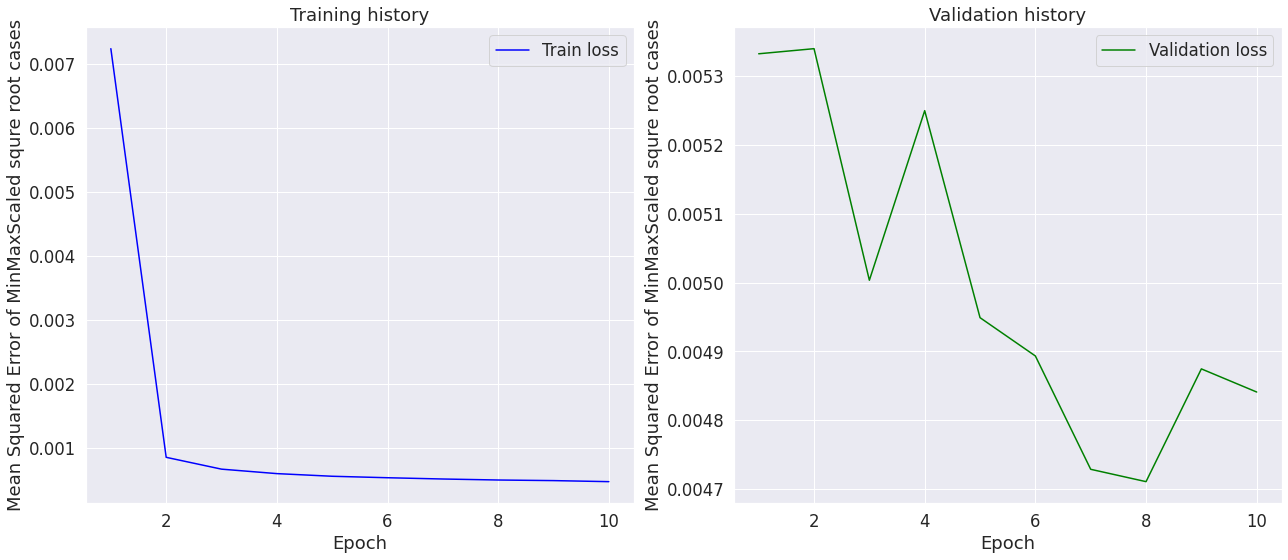

In [ ]:
plot_history(history)

# Inference

## Restore model

In [ ]:
import sys

if checkpointManager.latest_checkpoint:
    checkpoint.restore(checkpointManager.latest_checkpoint)
    print('Latest checkpoint restored: ' + checkpointManager.latest_checkpoint)
else:
    print('There are no checkpoints with those model parameters.')
    sys.exit(0)

transformer = checkpoint.model

Latest checkpoint restored: keras checkpoints/ckpt-6


## Evaluate

### Util

In [ ]:
def getPredictions(model, batches, config):
    num_static = len(config['static_locs'])
    num_future = len(config['future_locs'])
    num_target = len(config['target_loc'])

    num_unk = config['total_inputs'] - num_static - num_future - num_target
    weight_dict = {'static_flags': [], 'historical_flags': [], 'future_flags': [], 'decoder_self_attn': []}

    predictions = []
    actuals = []

    pb_i = Progbar(len(batches))
    for (batch, (input, target)) in enumerate(batches):
        prediction, attention_weights = test_step(model, input, target)

        for key in attention_weights.keys():
          weight_dict[key].append(np.array(attention_weights[key]))
        
        predictions.append(prediction)
        actuals.append(target)
        pb_i.update(batch)
    print()

    return np.concatenate(predictions), np.concatenate(actuals), weight_dict

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics

def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

def SMAPE(y_true, y_pred):
    value = 2*abs(y_true - y_pred) / (abs(y_true) + abs(y_pred))
    return np.mean(value)

def calculate_result(y_true, y_pred):
    mae = MAE(y_true, y_pred)
    rmse = RMSE(y_true, y_pred)
    smape = SMAPE(y_true, y_pred)

    return np.round(mae, 4), np.round(rmse, 4), np.round(smape, 4)

def scale_back(target):
    upscaled = target_scaler.inverse_transform([target.reshape(-1)])
    squared = np.square( upscaled[0].reshape((-1, target_sequence_length, 1)) )

    return squared

### Train

In [ ]:
train_inference, _ = dataProcessor.prepare_batch(train_data)
train_preds, train_actuals, train_attn_weights = getPredictions(
    transformer, train_inference, parameterManager.tft_params
)
train_actuals, train_preds = scale_back(train_actuals), scale_back(train_preds)
train_mae, train_rmse, train_smape = calculate_result(train_actuals, train_preds)
print(f'Train MAE {train_mae}, RMSE {train_rmse}, SMAPE {train_smape}')

4742/4743 [============================>.] - ETA: 0s
Train MAE 49.232, RMSE 178.7571, SMAPE 0.7855


In [ ]:
gc.collect()

10174

### Validation

In [ ]:
validation_preds, validation_actuals, validation_attn_weights = getPredictions(transformer, validation_batch, parameterManager.tft_params)

validation_preds, validation_actuals = scale_back(validation_preds), scale_back(validation_actuals)

validation_mae, validation_rmse, validation_smape = calculate_result(validation_actuals, validation_preds)
print(f'Validation MAE {validation_mae}, RMSE {validation_rmse}, SMAPE {validation_smape}')

474/477 [============================>.] - ETA: 0s
Validation MAE 221.2415, RMSE 644.1173, SMAPE 1.2453


### Test

In [ ]:
test_batch, _ = dataProcessor.prepare_batch(test_data)
test_preds, test_actuals, test_attn_weights = getPredictions(transformer, test_batch, parameterManager.tft_params)

test_actuals, test_preds = scale_back(test_actuals), scale_back(test_preds)

test_mae, test_rmse, test_smape = calculate_result(test_actuals, test_preds)
print(f'Test MAE {test_mae}, RMSE {test_rmse}, SMAPE {test_smape}')

474/477 [============================>.] - ETA: 0s
Test MAE 64.893, RMSE 202.1576, SMAPE 1.3138


In [ ]:
del transformer
gc.collect()

255

## Plot

In [ ]:
Nloc = df[parameterManager.col_mappings['ID']].nunique().values[0]
print(f'NLOC {Nloc}')
locs = df[parameterManager.col_mappings['ID']].iloc[:Nloc, 0].values

NLOC 500


### Util

In [ ]:
def sumCases(y_true, y_preds, number_of_locations):
    print('Predictions shape')
    print(y_preds.shape)

    sequence, times, feat = y_true.shape
    dseq = int(sequence / number_of_locations)

    # Construct new matrix to store averages
    #   shape = (Location x TimeSteps x Features)

    TargetMatrix = np.zeros((number_of_locations, dseq + times - 1, 1))
    PredMatrix = np.zeros((number_of_locations, dseq + times - 1, 1))
    locCounter = 0
    TimeCounter = 0

    for seq in range(sequence):
        if seq != 0 and seq % dseq == 0:
            # Reset Time counter and increment locations
            locCounter += 1
            TimeCounter = 0

        for TimeStep in range(times):  # TimeStep goes from 0 to 14 (length = 15)
            TargetMatrix[locCounter, TimeCounter + TimeStep] = y_true[seq, TimeStep]
            PredMatrix[locCounter, TimeCounter + TimeStep] += y_preds[seq, TimeStep]

        TimeCounter += 1

    # Divide matrix chunk would be used if we would like to average predictions for a given day. Given
    # that we have overlapping sequences, we will also have overlapping predictions. Currently we take first

    # Divide Matrix ---> to incorporate this into the above code
    for idx,i in enumerate(TargetMatrix):
        for jdx,j in enumerate(i):
            if jdx >= times-1 and jdx <= TargetMatrix.shape[1] - times:
                # TargetMatrix[idx,jdx] = np.divide(TargetMatrix[idx,jdx], times)
                PredMatrix[idx,jdx] = np.divide(PredMatrix[idx,jdx], times)
            else:
                divisor = min(abs(jdx+1), abs(TargetMatrix.shape[1]-jdx))
                # TargetMatrix[idx,jdx] = np.divide(TargetMatrix[idx,jdx], divisor)
                PredMatrix[idx,jdx] = np.divide(PredMatrix[idx,jdx], divisor)

    TargetMatrix = np.clip(TargetMatrix, 0, TargetMatrix.max() + 1)
    PredMatrix = np.clip(PredMatrix, 0, PredMatrix.max() + 1)

    print('Reshaped Preds')
    print(PredMatrix.shape)

    return TargetMatrix, PredMatrix

    # target_sum = np.sum(TargetMatrix, axis=0)
    # prediction_sum = np.sum(PredMatrix, axis=0)
    
    # return target_sum, prediction_sum

class PlotResults:
    def __init__(self, actuals, preds, start_date, locs, figPath):
        self.actuals = actuals
        self.Nloc = len(locs)
        self.preds = preds
        self.figPath = figPath
        self.locs = locs
        self.start_date = start_date

    def plot(self, y_true, y_preds, title, figsize=(24,8), scale=1000):
        dates = [self.start_date + np.timedelta64(days, 'D') for days in range(y_true.shape[0])]

        fig, ax = plt.subplots(figsize=figsize)
        plt.title(title)

        plt.plot(dates, y_true, color='blue', label='Observation')
        plt.plot(dates, y_preds, color='green', label='Prediction')

        label_text = [f'{int(cases/scale)}k' for cases in plt.yticks()[0]]
        ax.set_yticklabels(label_text)

        plt.xlabel('Date')
        plt.ylabel('Daily Cases')
        plt.legend()
        fig.tight_layout()
        # plt.savefig('Covid cases all counties.png', dpi=100)
        plt.show()

    def makeSummedPlot(self, title, figsize=(24,8), scale=1000):
        actuals_sum = np.sum(self.actuals, axis=0)
        preds_sum = np.sum(self.preds, axis=0)
        self.plot(actuals_sum, preds_sum, title, figsize, scale)

    
    def makeIndividualPlot(self, index, title, figure_name, figsize=(18,8), scale=1000):
        self.plot(self.actuals[index, :], self.preds[index, :], title, figure_name, figsize, scale)


### Train

Predictions shape
(303500, 15, 1)
Reshaped Preds
(500, 621, 1)


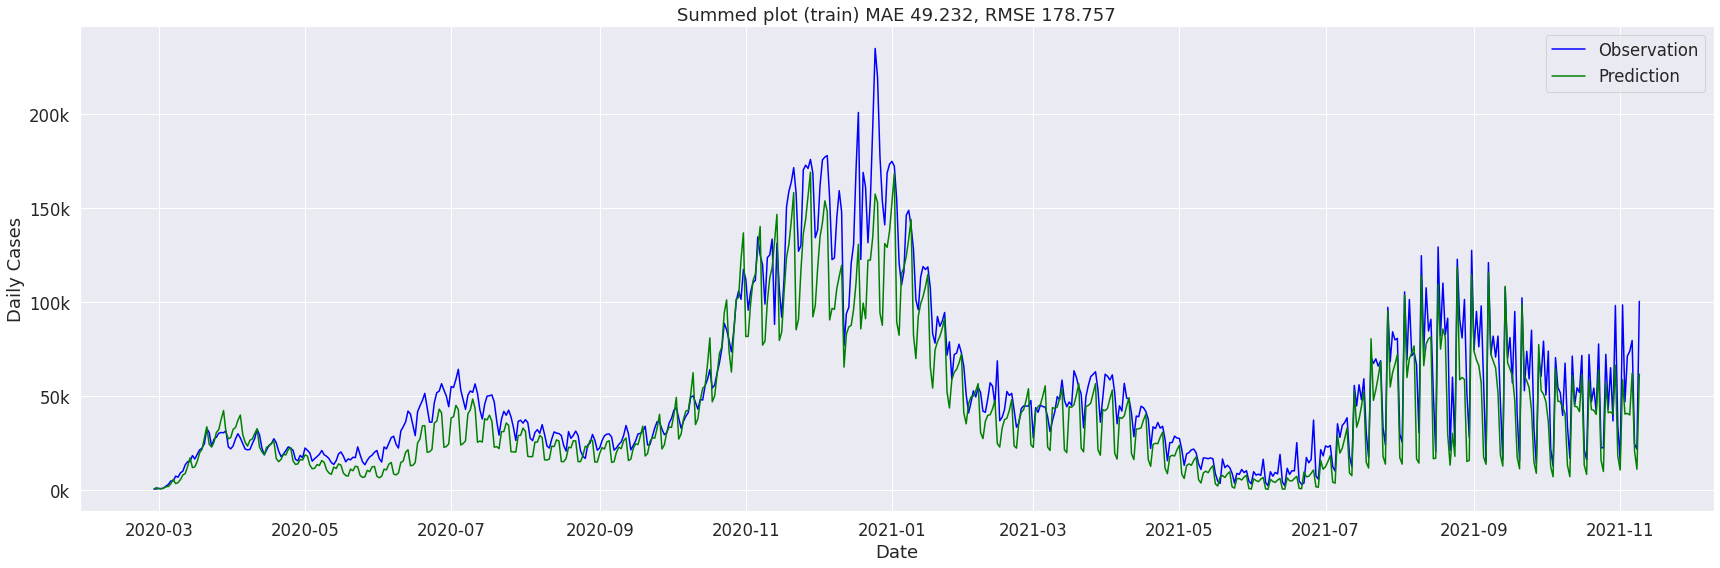

In [ ]:
targets, predictions = sumCases(train_actuals, train_preds, Nloc)

PlotC = PlotResults(targets, predictions, train_start, locs, figPath)
plot_title = f'Summed plot (train) MAE {train_mae:0.3f}, RMSE {train_rmse:0.3f}'

PlotC.makeSummedPlot(plot_title, figsize=(24, 8))

### Validation

Predictions shape
(30500, 15, 1)
Reshaped Preds
(500, 75, 1)


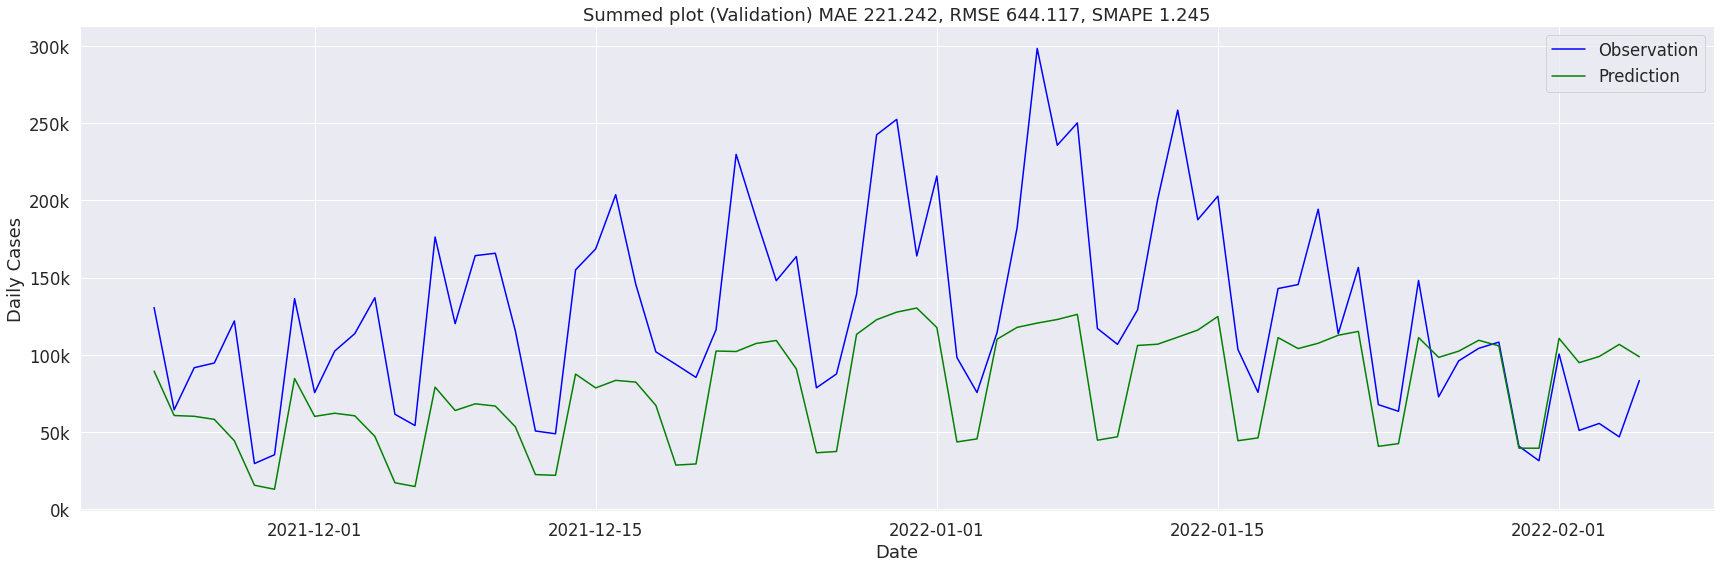

In [ ]:
targets, predictions = sumCases(validation_actuals, validation_preds, Nloc)
PlotC = PlotResults(targets, predictions, validation_start, locs, figPath)
plot_title = f'Summed plot (Validation) MAE {validation_mae:0.3f}, RMSE {validation_rmse:0.3f}, SMAPE {validation_smape:0.3f}'

PlotC.makeSummedPlot(plot_title)

### Test

Predictions shape
(30500, 15, 1)
Reshaped Preds
(500, 75, 1)


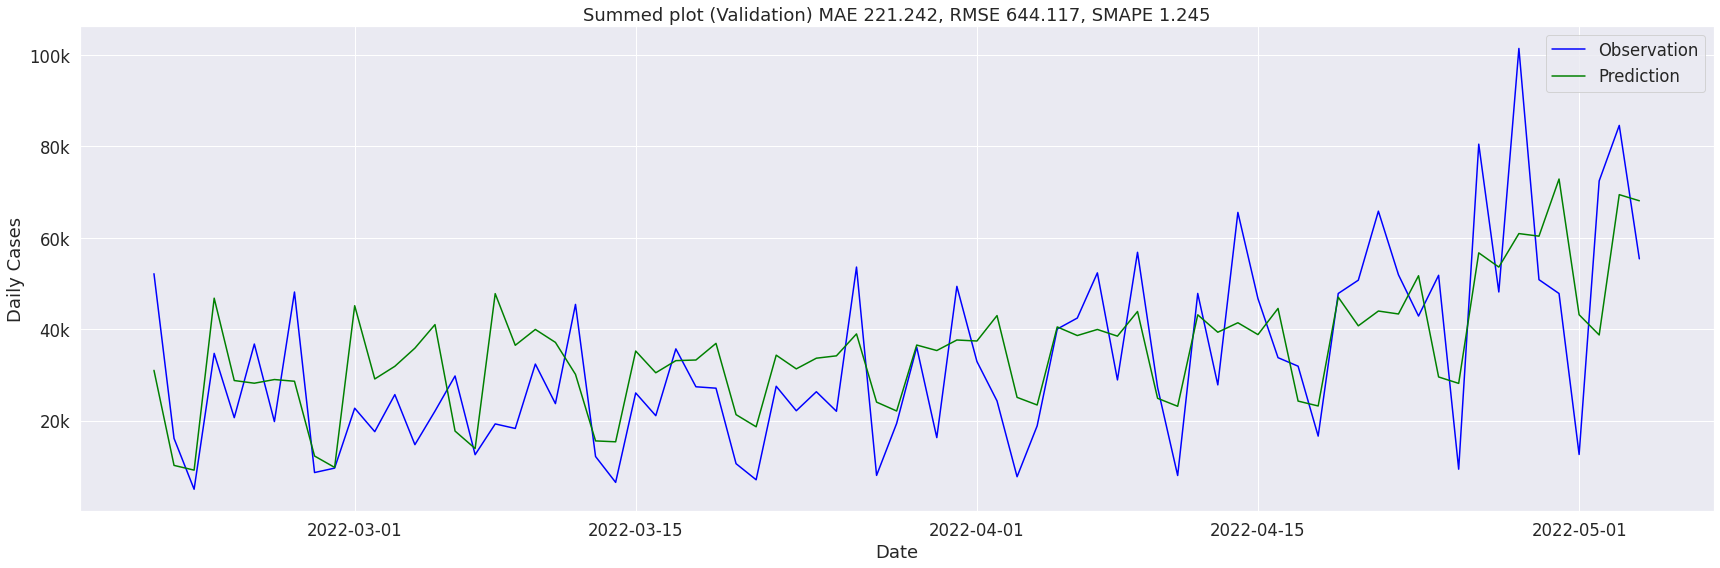

In [ ]:
targets, predictions = sumCases(test_actuals, test_preds, Nloc)
PlotC = PlotResults(targets, predictions, test_start, locs, figPath)
plot_title = f'Summed plot (Validation) MAE {validation_mae:0.3f}, RMSE {validation_rmse:0.3f}, SMAPE {validation_smape:0.3f}'

PlotC.makeSummedPlot(plot_title)

# Interpret

## Util

In [ ]:
class PlotWeights:
    def __init__(self, attention, figPath):
        self.attention = attention
        self.figPath = figPath

    def plot_weights(self, key, feature_list, title, figsize=(15, 8)):
        ff = np.concatenate(self.attention[key], axis=0)
        if 'static' not in key:
            ff = ff.mean(axis=1)

        quantiles = [.3, .5, .7]

        ff_qt = np.quantile(ff, quantiles, axis=0)

        N = len(feature_list)
        X = np.arange(N)
        width = 0.25

        fig, ax = plt.subplots(figsize=(15, 8))

        rects1 = ax.bar(X - width, ff_qt[0], width, label='0.3 quantile')
        rects2 = ax.bar(X, ff_qt[1], width, label='0.5 quantile')
        rects3 = ax.bar(X + width, ff_qt[2], width, label='0.5 quantile')
        ax.set_ylabel('Variable Selection Network Weight')
        ax.set_xlabel('Weight by Quantile and Feature')
        ax.set_title(title)

        ax.set_xticks(X)
        ax.set_xticklabels(feature_list)

        ax.tick_params(labelrotation=45)
        fig.tight_layout()
        plt.legend()
        plt.show()


    def plot_future_weights(self, figsize=(15,8)):
        self.plot_weights('future_flags', col_mappings['Future'], title='Future known input selection weights by variable', figsize=figsize)

    def plot_static_weights(self, figsize=(15,8)):
        self.plot_weights('static_flags', col_mappings['Static'], title='Static input selection weights by variable', figsize=figsize)

    def plotObservedWeights(self, figsize=(15,8)):
        feature_list = col_mappings['Known Regular'] + col_mappings['Future'] + col_mappings['Target']
        feature_list = [f for f in feature_list if f not in col_mappings['Static']]

        self.plot_weights('historical_flags', feature_list, title='Observed input selection weights by variable', figsize=figsize)

In [ ]:
plotter = PlotWeights(train_attn_weights, figPath)

## Static variables

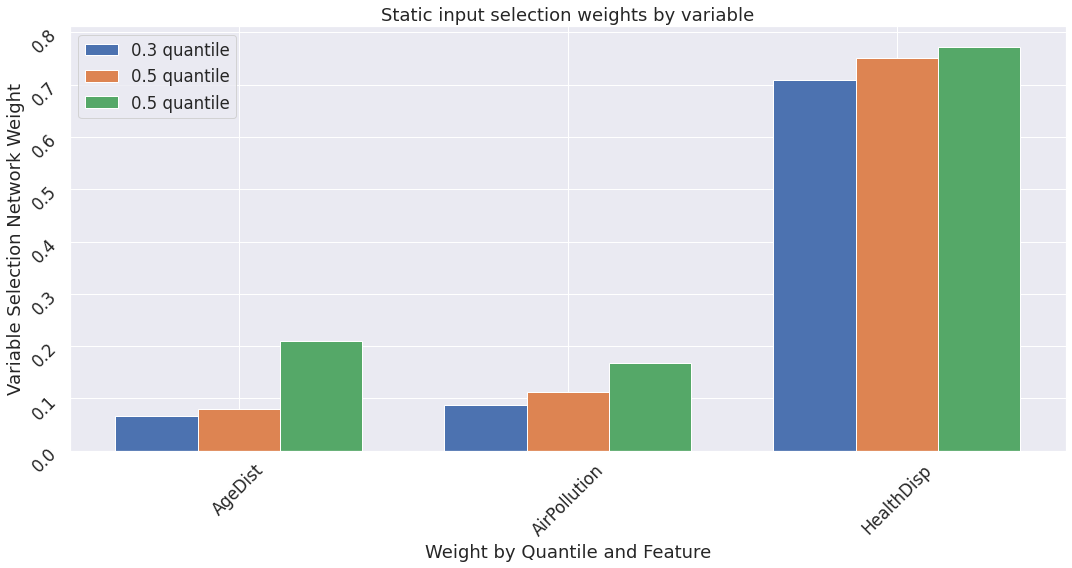

In [ ]:
plotter.plot_static_weights()

## Future known input

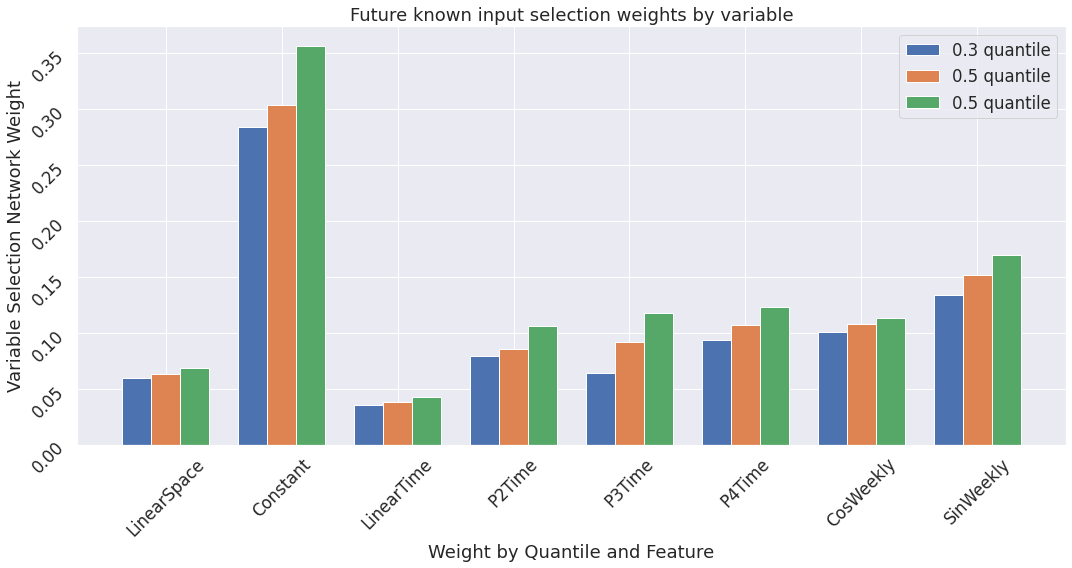

In [ ]:
plotter.plot_future_weights()

## Observed weights

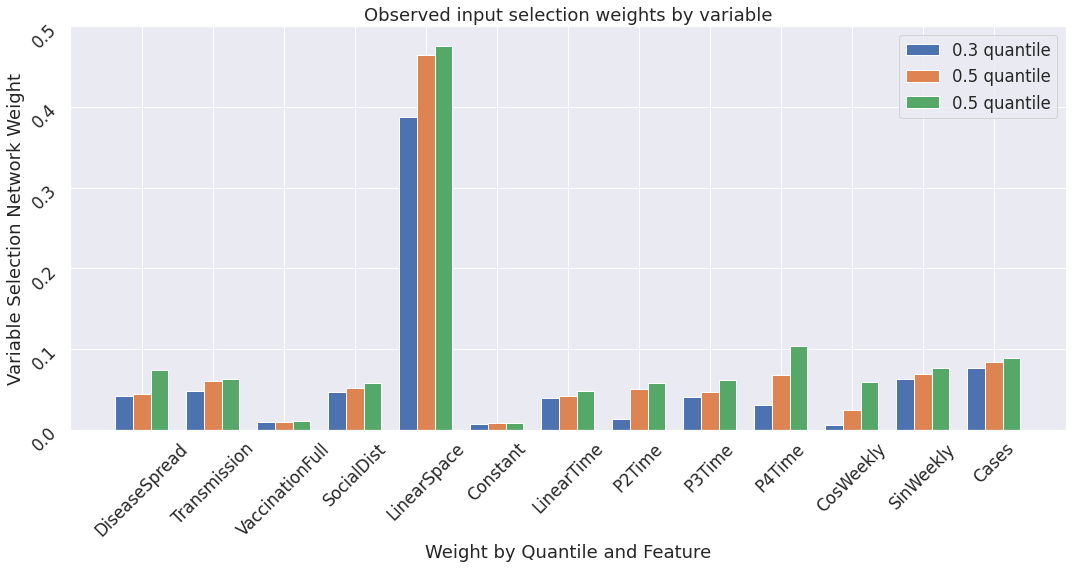

In [ ]:
plotter.plotObservedWeights()

In [ ]:
gc.collect()

20896